Making separate models for different Task IDs, repeating them several times and taking the average AUC.<br>
This model does not take into account second try.

In [19]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
filepath2 = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors2 = json.load(open(filepath))
student_vectors = json.load(open(filepath2))

In [21]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

Number of unique task IDs: 10
Number of students: 11659


In [22]:
split = int(0.8*len(student_vectors))
print(split)

9327


In [23]:
import math
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def calculate_auc (y_true,y_pred,sequence_lengths=[],plot=False):
    if sequence_lengths == []:
        return roc_auc_score(y_true, y_pred)
    else:
        con_y_true = np.zeros([sum(sequence_lengths)])
        con_y_pred = np.zeros([sum(sequence_lengths)])
        index = 0
        for i in range(len(y_true)): #per student
            for j in range(sequence_lengths[i]): #up to the sequence length
                con_y_true[index] = y_true[i][j]
                if(plot):
                    con_y_pred[index] = y_pred[0][i][j]
                else:
                    con_y_pred[index] = y_pred[i][j]
                index += 1
        fpr, tpr, thresholds = roc_curve(con_y_true, con_y_pred)
        #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
        
        if(plot):
            return [roc_auc_score(con_y_true, con_y_pred),fpr,tpr]
        else:
            return roc_auc_score(con_y_true, con_y_pred)

def o_calculate_auc(true_all_tasks, predictions_all_tasks, sequence_lengths_all_tasks,plot=False):
    total = 0
    for i in sequence_lengths_all_tasks:
        total += sum(sequence_lengths_all_tasks[i])
    index = 0
    con_y_true = np.zeros([total])
    con_y_pred = np.zeros([total])
    for i in sequence_lengths_all_tasks: #per task ID
        for j in range(len(true_all_tasks[i])): #per student
            for k in range(sequence_lengths_all_tasks[i][j]): #up to sequence length
                con_y_true[index] = true_all_tasks[i][j][k]
                con_y_pred[index] = predictions_all_tasks[i][0][j][k]
                index += 1
    fpr, tpr, thresholds = roc_curve(con_y_true, con_y_pred)
    #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
    if(plot == True):
        return [roc_auc_score(con_y_true, con_y_pred),fpr,tpr]
    else:
        return roc_auc_score(con_y_true, con_y_pred)


In [8]:
#recorders over task IDs
test_AUC_all_tasks = {} #making AUC plot over epochs over all task IDs
train_AUC_all_tasks = {} #making AUC plot over epochs over all task IDs
true_all_tasks = {}
true_all_tasks['train'] = {}
true_all_tasks['test'] = {}
predictions_all_tasks = {}
predictions_all_tasks['train'] = {}
predictions_all_tasks['test'] = {}
seqlen_all_tasks = {}
seqlen_all_tasks['train'] = {}
seqlen_all_tasks['test'] = {}
np.set_printoptions(threshold=np.nan)

for i in another_2:
    
    print("\n\n\nCalculating for Task ID: "+str(i)+" which has the frequency: " + str(cnt2[another_2[i]]) + "\n")
    
    #recorders over epochs
    train_AUC_taski = [] #making AUC plot over epochs
    test_AUC_taski = [] # making AUC plot over epochs
    
    #configuration variables
    len_vector = 1 #length of input encoding, number of input units and number of output units
    padding_experiment = 1000. #to check if masking is working correctly or not
    num_units = 5 #number of recurrent units
    l_rate = 0.01 #initial learning rate
    epochs = 1000 #when in fixed number of epochs
    display_ep = 20 #status report after 'display_ep' epochs, and convergence criterion
    repeat = 1 #number of times to repeat experiments, recorders work according to 1 right now
    
    #make sequences
    sequences = []
    sequences_lengths = []
    sequences_lengths1 = [] #for passing to mask
    for p in student_vectors:
        interactions = []
        interactions.append([padding_experiment]) #for getting the first prediction!
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    interactions.append([1.])
                else:
                    interactions.append([0.])
        if(len(interactions) > 1):
            sequences_lengths.append(len(interactions)-1)
            sequences_lengths1.append([len(interactions)-1]) 
            sequences.append(interactions)
            
    #add padding
    padded_sequences = np.zeros([len(sequences),max(sequences_lengths)+1,len_vector])
    padded_sequences = padded_sequences + padding_experiment
    for p in range(len(sequences)):
        for j in range(len(sequences[p])):
            padded_sequences[p][j] = sequences[p][j]
    
    split = int(0.8*len(sequences)) #train/test split
    #split the train and test set
    train_x = padded_sequences[:split,:-1]
    train_y = padded_sequences[:split,1:]
    train_seqlen = sequences_lengths[:split]
    test_x = padded_sequences[split:,:-1]
    test_y = padded_sequences[split:,1:]
    test_seqlen = sequences_lengths[split:]
    
    for r in range(repeat): #don't have to repeat results since we fixed the random state
        print("\n\n"+ str(r+1) +" out of "+ str(repeat) + " Time Run.")
        
        # reset graph, fix random seed
        tf.reset_default_graph()
        tf.set_random_seed(1234) #fixing the random states for repeating results
        
        #placeholders
        x = tf.placeholder(tf.float32, [None, max(sequences_lengths), len_vector])
        y = tf.placeholder(tf.float32, [None, max(sequences_lengths), len_vector])
        seqlen_tf = tf.placeholder(tf.float32,[None])
        condition = tf.placeholder(tf.int32, shape=[], name="condition")

        #dynamic RNN definition
        def dynamicRNN(x):
            rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units)
            outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32,sequence_length=seqlen_tf)
            out_size = len_vector
            outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
            #outputs = tf.nn.sigmoid(outputs)
            return outputs
        
        #making predictions and masking cost to feed optimizer
        pred = dynamicRNN(x)

        cost1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y)
        mask = tf.cond(condition < 1, lambda: tf.cast(tf.sequence_mask(lengths=sequences_lengths1[:split], maxlen = max(sequences_lengths)), tf.float32), lambda: tf.cast(tf.sequence_mask(lengths=sequences_lengths1[split:], maxlen = max(sequences_lengths)), tf.float32))
        cost1 = tf.multiply(cost1,tf.transpose(mask, perm=[0, 2, 1]))
        cost1 = tf.reduce_sum(cost1, 1)
        cost1 /= tf.cond(condition < 1, lambda: tf.cast(sequences_lengths1[:split],tf.float32), lambda: tf.cast(sequences_lengths1[split:],tf.float32) )
        cost = tf.reduce_mean(cost1)
        optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(cost)

        #execute until cost converges
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.local_variables_initializer())
            stop = False
            epoch = 0
            cost_prev = 1.0
            while(stop == False):
                epoch += 1
                loss,_ = sess.run([cost,optimizer], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
                
                #status report
                if epoch % display_ep == 0 or epoch == 1:
                    
                    loss_train,pred_train = sess.run([cost,pred], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
                    trainOPTS = calculate_auc(train_y,pred_train,train_seqlen)
                    
                    loss_test,pred_test = sess.run([cost,pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
                    testOPTS = calculate_auc(test_y,pred_test,test_seqlen)
                    #print(np.c_[train_y[np.argmax(train_seqlen)][:train_seqlen[np.argmax(train_seqlen)]],pred_train[np.argmax(train_seqlen)][:train_seqlen[np.argmax(train_seqlen)]]])
                    print("Epoch: " + str(epoch) +", train cost: "+str(loss_train)+", test cost: "+str(loss_test)+ ", train set AUC: " + str(trainOPTS) + ", test set AUC: "+ str(testOPTS) +";")
                    train_AUC_taski.append(trainOPTS)
                    test_AUC_taski.append(testOPTS)
                    
                    #checking for convergence
                    cost_current = loss_train
                    if abs(cost_prev - cost_current) <= 0.00005:
                        stop = True
                    else:
                        cost_prev = cost_current

            pred_train = sess.run([pred], feed_dict={x: train_x, y: train_y, seqlen_tf: train_seqlen,condition:0})
            predictions_all_tasks['train'][i] = pred_train
            true_all_tasks['train'][i] = train_y
            seqlen_all_tasks['train'][i] = train_seqlen
            pred_test = sess.run([pred], feed_dict={x: test_x, y: test_y, seqlen_tf: test_seqlen,condition:1})
            true_all_tasks['test'][i] = test_y
            predictions_all_tasks['test'][i] = pred_test
            seqlen_all_tasks['test'][i] = test_seqlen
    
    test_AUC_all_tasks[i] = test_AUC_taski
    train_AUC_all_tasks[i] = train_AUC_taski




Calculating for Task ID: 1zsCldT4p8.set1 which has the frequency: 76458



1 out of 1 Time Run.
Epoch: 1, train cost: 0.5786447, test cost: 0.5817356, train set AUC: 0.4791244899522155, test set AUC: 0.4835448435955034;
Epoch: 20, train cost: 0.51909435, test cost: 0.5234596, train set AUC: 0.5728727053862095, test set AUC: 0.561108743664142;
Epoch: 40, train cost: 0.47969297, test cost: 0.48522028, train set AUC: 0.5767263503483699, test set AUC: 0.5643319464643992;
Epoch: 60, train cost: 0.46261615, test cost: 0.467723, train set AUC: 0.5962375734248566, test set AUC: 0.5846829093528305;
Epoch: 80, train cost: 0.46048528, test cost: 0.46560156, train set AUC: 0.5956861300378924, test set AUC: 0.5837656049004503;
Epoch: 100, train cost: 0.45966202, test cost: 0.46477684, train set AUC: 0.59575330066933, test set AUC: 0.5838176349849764;
Epoch: 120, train cost: 0.45920604, test cost: 0.46431747, train set AUC: 0.594706100182561, test set AUC: 0.582451615583811;
Epoch: 140, train cos

Epoch: 160, train cost: 0.4693273, test cost: 0.4816593, train set AUC: 0.6222901690889125, test set AUC: 0.611054531097983;
Epoch: 180, train cost: 0.46920893, test cost: 0.48154783, train set AUC: 0.6222272123527756, test set AUC: 0.6109240011904093;
Epoch: 200, train cost: 0.4691184, test cost: 0.48146245, train set AUC: 0.6222066896231746, test set AUC: 0.6109385451162813;
Epoch: 220, train cost: 0.46904847, test cost: 0.48139486, train set AUC: 0.6221458586267749, test set AUC: 0.610847590765791;
Epoch: 240, train cost: 0.46899155, test cost: 0.48134074, train set AUC: 0.6221001602716875, test set AUC: 0.610658446644402;
Epoch: 260, train cost: 0.4689457, test cost: 0.48129582, train set AUC: 0.6220446638216829, test set AUC: 0.6105823651025296;



Calculating for Task ID: 1zsCldT4p8.set2 which has the frequency: 75166



1 out of 1 Time Run.
Epoch: 1, train cost: 0.55943525, test cost: 0.56031907, train set AUC: 0.40042516674401324, test set AUC: 0.4091078408612281;
Epoch: 20, tr

Epoch: 340, train cost: 0.4558819, test cost: 0.4538692, train set AUC: 0.4842767701475921, test set AUC: 0.47897378577787963;



Calculating for Task ID: 2yCqg9SbT0.set1 which has the frequency: 46153



1 out of 1 Time Run.
Epoch: 1, train cost: 0.6039132, test cost: 0.6036057, train set AUC: 0.441629256276469, test set AUC: 0.41764003588032067;
Epoch: 20, train cost: 0.56235486, test cost: 0.5607174, train set AUC: 0.5543359461729039, test set AUC: 0.5315494247419602;
Epoch: 40, train cost: 0.5383369, test cost: 0.5358244, train set AUC: 0.5572214904241924, test set AUC: 0.5361555875735733;
Epoch: 60, train cost: 0.52996904, test cost: 0.52633476, train set AUC: 0.5767506309772952, test set AUC: 0.5647682773714067;
Epoch: 80, train cost: 0.5290186, test cost: 0.52528656, train set AUC: 0.575081170853676, test set AUC: 0.5631527632645228;
Epoch: 100, train cost: 0.528655, test cost: 0.52487934, train set AUC: 0.5752147965546546, test set AUC: 0.5635604154226733;
Epoch: 120, train cos

In [9]:
print("Calculating over-all AUC")
o_train = o_calculate_auc(true_all_tasks['train'],predictions_all_tasks['train'],seqlen_all_tasks['train'],plot=False)
o_test = o_calculate_auc(true_all_tasks['test'],predictions_all_tasks['test'],seqlen_all_tasks['test'],plot=False)
print("Overall AUC train: "+str(o_train) + ", test: "+str(o_test))

Calculating over-all AUC
Overall AUC train: 0.5958619022045346, test: 0.5886003039202572


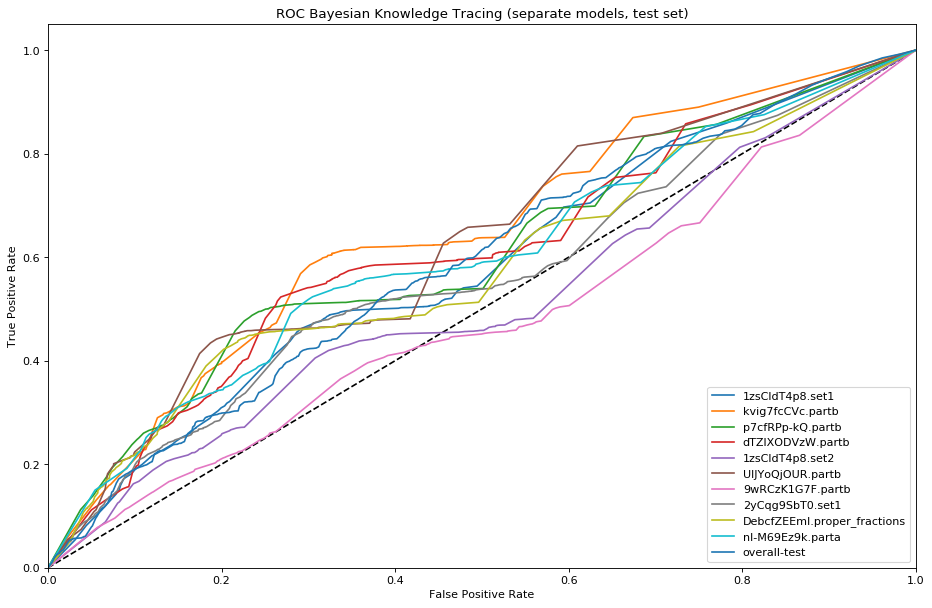

In [10]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (separate models, test set)')

for task_id in another_2:
    roc = calculate_auc(true_all_tasks['test'][task_id] , predictions_all_tasks['test'][task_id] , seqlen_all_tasks['test'][task_id],plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = o_calculate_auc(true_all_tasks['test'],predictions_all_tasks['test'],seqlen_all_tasks['test'],plot=True)
plt.plot(roc[1], roc[2], label='overall-test')

plt.legend(loc="lower right")

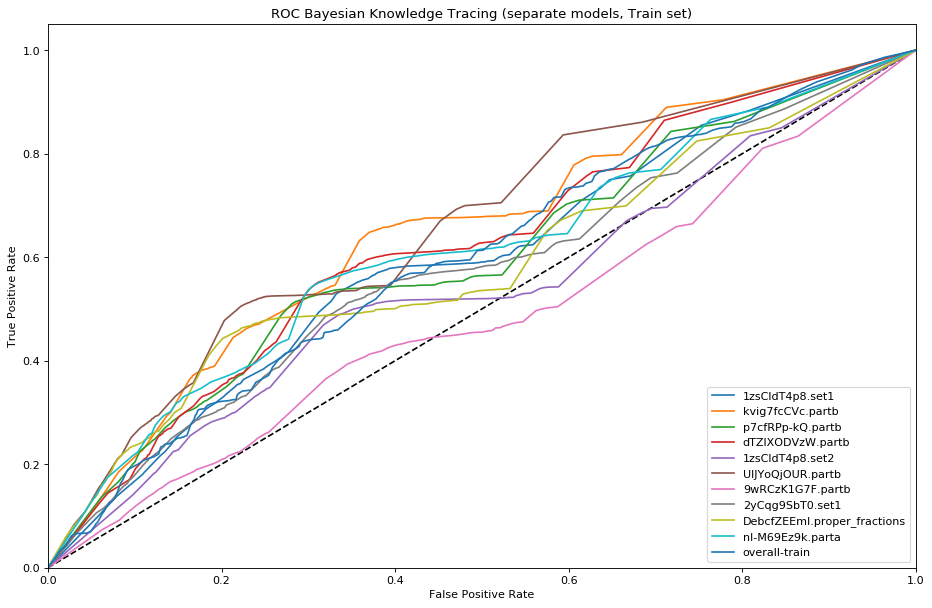

In [11]:
fig=plt.figure(figsize=(14, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Bayesian Knowledge Tracing (separate models, Train set)')

for task_id in another_2:
    roc = calculate_auc(true_all_tasks['train'][task_id],predictions_all_tasks['train'][task_id], seqlen_all_tasks['train'][task_id], plot=True)
    plt.plot(roc[1], roc[2], label=task_id)

roc = o_calculate_auc(true_all_tasks['train'],predictions_all_tasks['train'],seqlen_all_tasks['train'],plot=True)
plt.plot(roc[1], roc[2], label='overall-train')

plt.legend(loc="lower right")

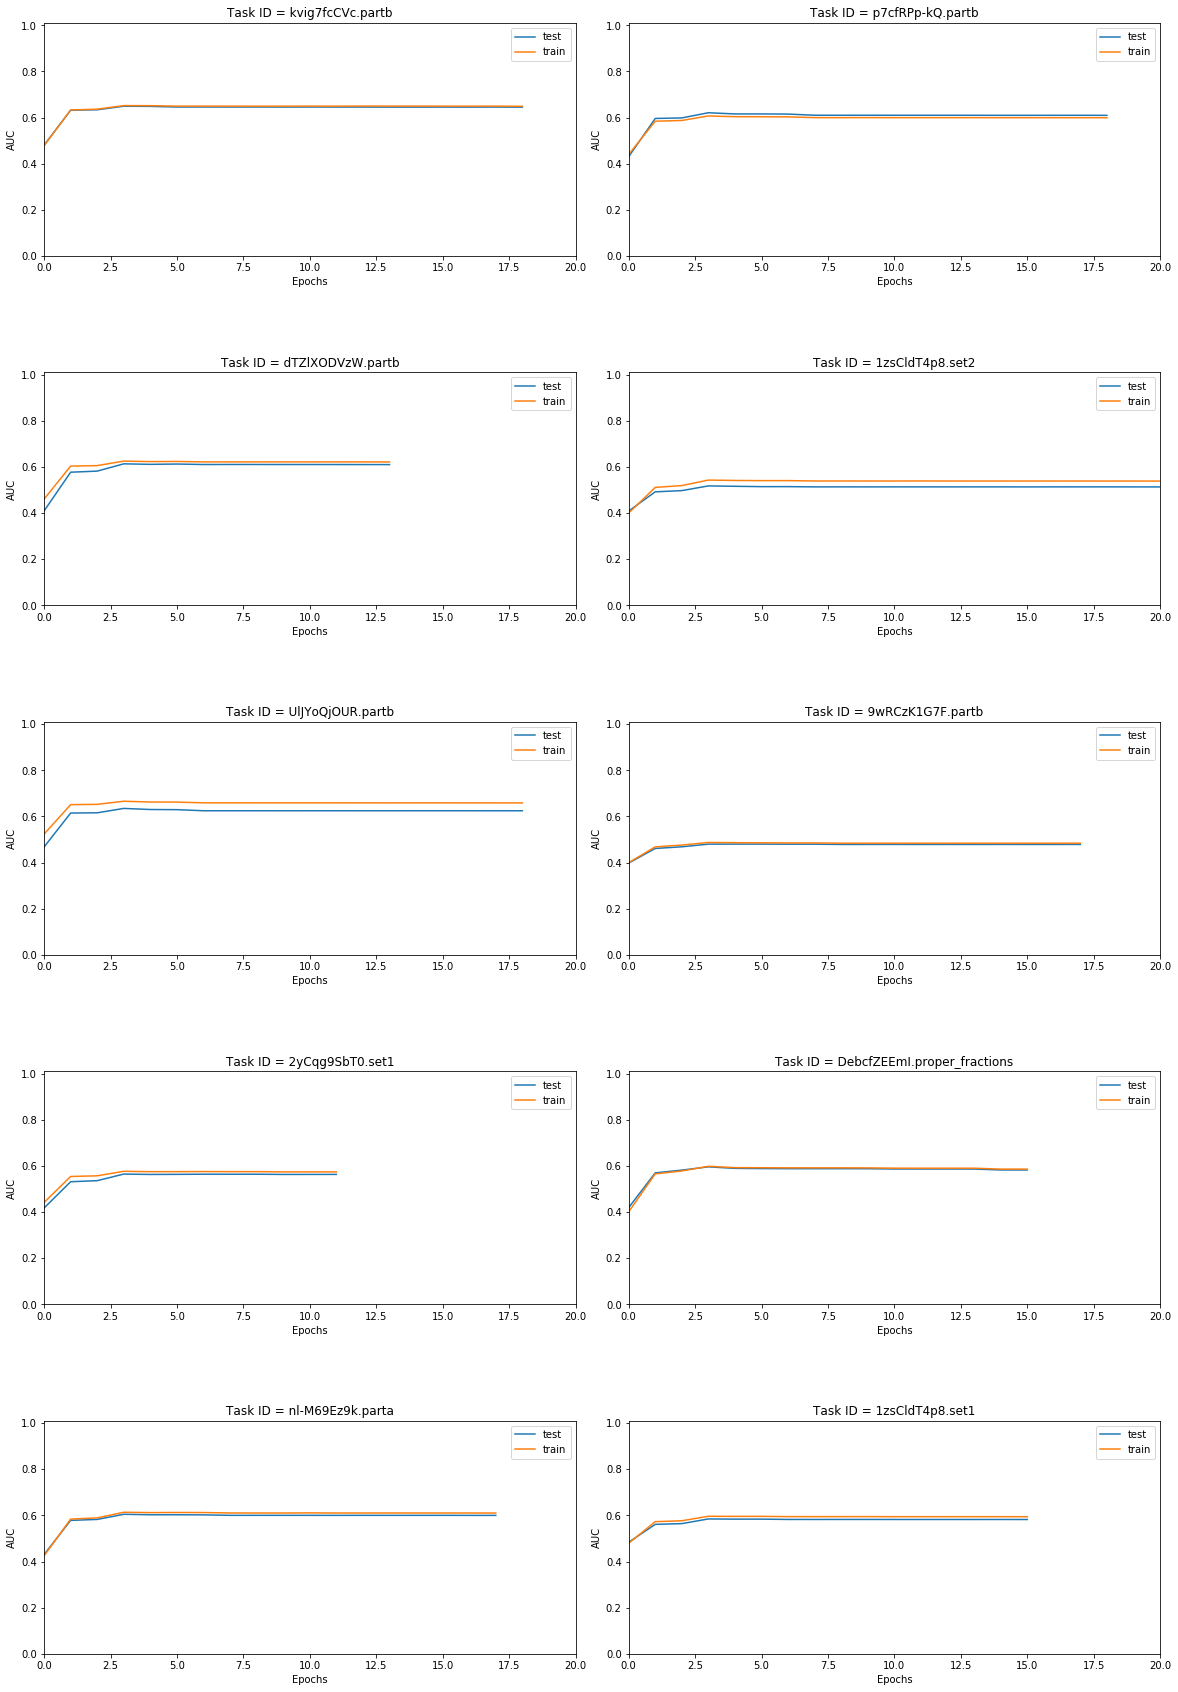

In [12]:
fig, axs = plt.subplots(5,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    axs[i-1].plot(test_AUC_all_tasks[value],label='test')
    axs[i-1].plot(train_AUC_all_tasks[value],label='train')
    axs[i-1].set_ylim(0,1.01)
    axs[i-1].set_xlim(0,20)
    axs[i-1].set_xlabel("Epochs")
    axs[i-1].set_ylabel("AUC")
    axs[i-1].legend(loc="best")
    axs[i-1].set_title("Task ID = "+str(value))

In [14]:
for i in another_2:
    print(i + " final train auc: " + str(round(train_AUC_all_tasks[i][-1],3)) + "; final test auc: "+str(round(test_AUC_all_tasks[i][-1],3)))

1zsCldT4p8.set1 final train auc: 0.594; final test auc: 0.582
kvig7fcCVc.partb final train auc: 0.649; final test auc: 0.645
p7cfRPp-kQ.partb final train auc: 0.599; final test auc: 0.61
dTZlXODVzW.partb final train auc: 0.622; final test auc: 0.611
1zsCldT4p8.set2 final train auc: 0.539; final test auc: 0.514
UlJYoQjOUR.partb final train auc: 0.659; final test auc: 0.625
9wRCzK1G7F.partb final train auc: 0.484; final test auc: 0.479
2yCqg9SbT0.set1 final train auc: 0.574; final test auc: 0.563
DebcfZEEmI.proper_fractions final train auc: 0.586; final test auc: 0.582
nl-M69Ez9k.parta final train auc: 0.61; final test auc: 0.6


Visualizing Data

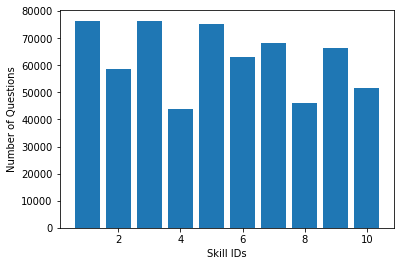

Task IDs mapping: 
Task ID -> 1zsCldT4p8.set1(1) is attempted 76458 times. Max seq len: 240
Task ID -> kvig7fcCVc.partb(2) is attempted 58768 times. Max seq len: 61
Task ID -> p7cfRPp-kQ.partb(3) is attempted 76279 times. Max seq len: 147
Task ID -> dTZlXODVzW.partb(4) is attempted 43769 times. Max seq len: 137
Task ID -> 1zsCldT4p8.set2(5) is attempted 75166 times. Max seq len: 210
Task ID -> UlJYoQjOUR.partb(6) is attempted 63034 times. Max seq len: 193
Task ID -> 9wRCzK1G7F.partb(7) is attempted 68238 times. Max seq len: 180
Task ID -> 2yCqg9SbT0.set1(8) is attempted 46153 times. Max seq len: 119
Task ID -> DebcfZEEmI.proper_fractions(9) is attempted 66271 times. Max seq len: 132
Task ID -> nl-M69Ez9k.parta(10) is attempted 51483 times. Max seq len: 145


In [24]:
#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
seqlen_tasks = {}
temp_seqlen = {}
position_2 = 1
for i in student_vectors:
    for k in temp_seqlen:
        temp_seqlen[k] = 0
    for j in student_vectors[i]:
        if(j['second_try'] == False):
            if j['task_id'] not in another_2:
                another_2[j['task_id']] = str(position_2)
                position_2 = position_2 + 1
            if j['task_id'] not in seqlen_tasks:
                seqlen_tasks[j['task_id']] = []

            if j['task_id'] not in temp_seqlen:
                temp_seqlen[j['task_id']] = 1
            else:
                temp_seqlen[j['task_id']] += 1
            cnt2[another_2[j['task_id']]] += 1
    for k in seqlen_tasks:
        seqlen_tasks[k].append(temp_seqlen[k])
        
umm = np.zeros([10])
umm2 = np.zeros([10])
for i in cnt2:
    umm2[int(i)-1] = cnt2[i]
    umm[int(i)-1] = str(i)
fig, ax = plt.subplots()
ind = np.arange(10) 
ax.bar(ind+1,umm2)
#plt.title("Skill frequency distribution")
ax.set_xlabel("Skill IDs")
ax.set_ylabel("Number of Questions")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times." + " Max seq len: "+str(max(seqlen_tasks[i])))

70861
5597
55467
3301
61572
14707
39523
4246
61565
13601
51524
11510
54271
13967
40045
6108
53566
12705
41722
9761


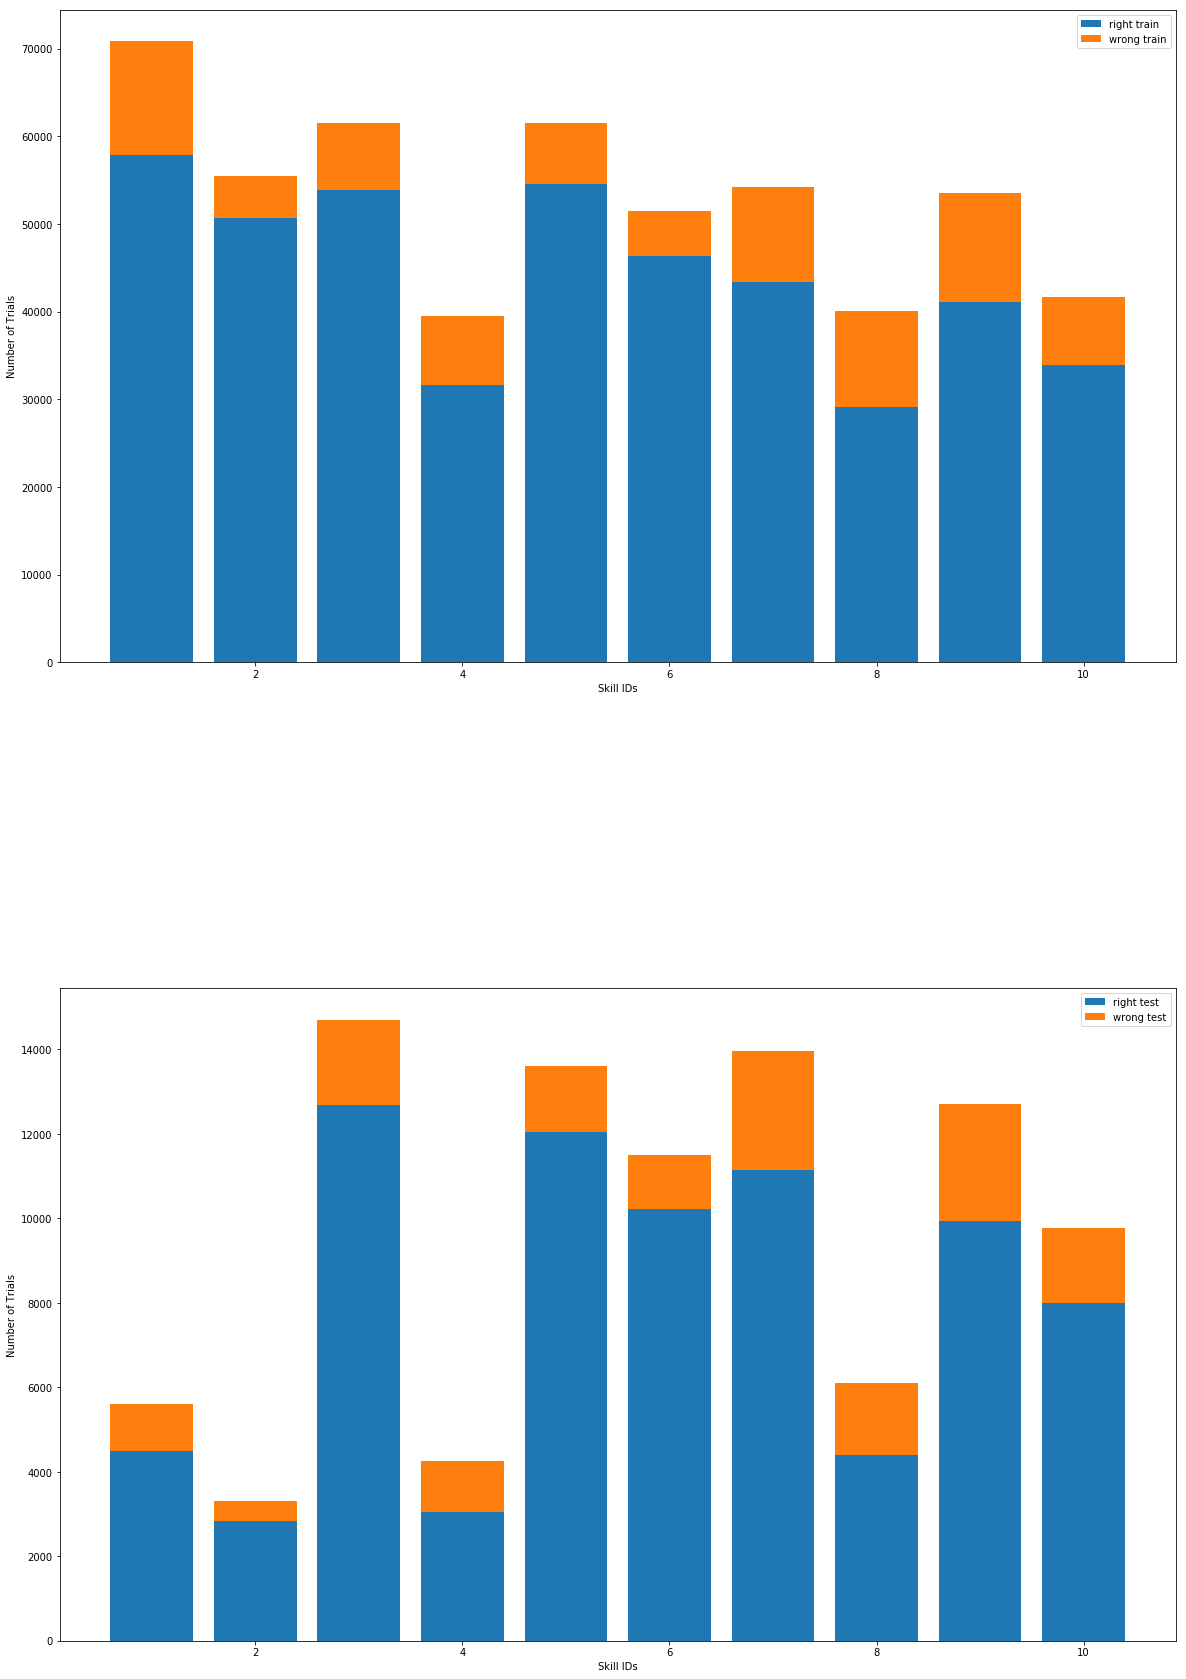

In [40]:
right_ = {}
right_['train'] = np.zeros([10])
right_['test'] = np.zeros([10])
wrong_ = {}
wrong_['train'] = np.zeros([10])
wrong_['test'] = np.zeros([10])
for k in another_2:
    index_tr = 0
    index_te = 0
    right_tr = 0
    right_te = 0
    for idx,i in enumerate(student_vectors):
        if(idx<split): #training set
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    index_tr += 1
                    if(j['correct'] == True):
                        right_tr += 1
        else:
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    index_te += 1
                    if(j['correct'] == True):
                        right_te += 1
    right_['train'][int(another_2[k])-1] = right_tr
    wrong_['train'][int(another_2[k])-1] = index_tr - right_tr
    right_['test'][int(another_2[k])-1] = right_te
    wrong_['test'][int(another_2[k])-1] = index_te - right_te
    print(index_tr)
    print(index_te)

fig, axs = plt.subplots(2,1, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.10)

axs = axs.ravel()
for i in range(1):
    N = 10
    ind = np.arange(N)+1
    for k in ['train','test']:
        if(k=='train'):
            axs[2*i].bar(ind,right_[k],label="right "+str(k))
            axs[2*i].bar(ind,wrong_[k],bottom = right_[k],label="wrong "+str(k))
            #axs[i].set_ylim(0,1.31)
            axs[2*i].legend(loc="best") 
            axs[2*i].set_xlabel("Skill IDs")
            axs[2*i].set_ylabel("Number of Trials")
        else:
            axs[2*i+1].bar(ind,right_[k],label="right "+str(k))
            axs[2*i+1].bar(ind,wrong_[k],bottom = right_[k],label="wrong "+str(k))
            #axs[i].set_ylim(0,1.31)
            axs[2*i+1].legend(loc="best") 
            axs[2*i+1].set_xlabel("Skill IDs")
            axs[2*i+1].set_ylabel("Number of Trials")
plt.savefig('right_wrong_10x.png')

In [15]:
proportion_right_train = {}
proportion_right_test = {}
proportion_wrong_train = {}
proportion_wrong_test = {}
num_of_students_train = {}
num_of_students_test = {}

for k in another_2:
    proportion_right_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_right_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    proportion_wrong_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students_train[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    num_of_students_test[k] = np.zeros((max(seqlen_tasks[k])),dtype=np.float64)
    for idx,i in enumerate(student_vectors):
        if(idx<split): #training set
            question_number = 0
            right_wrong = []
            did_student_attempt = False
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    question_number += 1
                    did_student_attempt = True
                    if(j['correct'] == True):
                        right_wrong.append('right')
                    else:
                        right_wrong.append('wrong')
            if(did_student_attempt):
                for l in range(question_number):
                    num_of_students_train[k][l] += 1
                    if(right_wrong[l] == 'right'):
                        proportion_right_train[k][l] += 1
        else: #test set
            question_number = 0
            right_wrong = []
            did_student_attempt = False
            for j in student_vectors[i]:
                if(j['second_try'] == False and j['task_id'] == k):
                    question_number += 1
                    did_student_attempt = True
                    if(j['correct'] == True):
                        right_wrong.append('right')
                    else:
                        right_wrong.append('wrong')
            if(did_student_attempt):
                for l in range(question_number):
                    num_of_students_test[k][l] += 1
                    if(right_wrong[l] == 'right'):
                        proportion_right_test[k][l] += 1
    for g in range(max(seqlen_tasks[k])):
        proportion_right_train[k][g] = round((proportion_right_train[k][g]),4)
        proportion_right_test[k][g] = round((proportion_right_test[k][g]),4)
        proportion_wrong_train[k][g] = round((num_of_students_test[k][g]) - proportion_right_train[k][g],4)
        proportion_wrong_test[k][g] = round((num_of_students_test[k][g]) - proportion_right_test[k][g],4)        

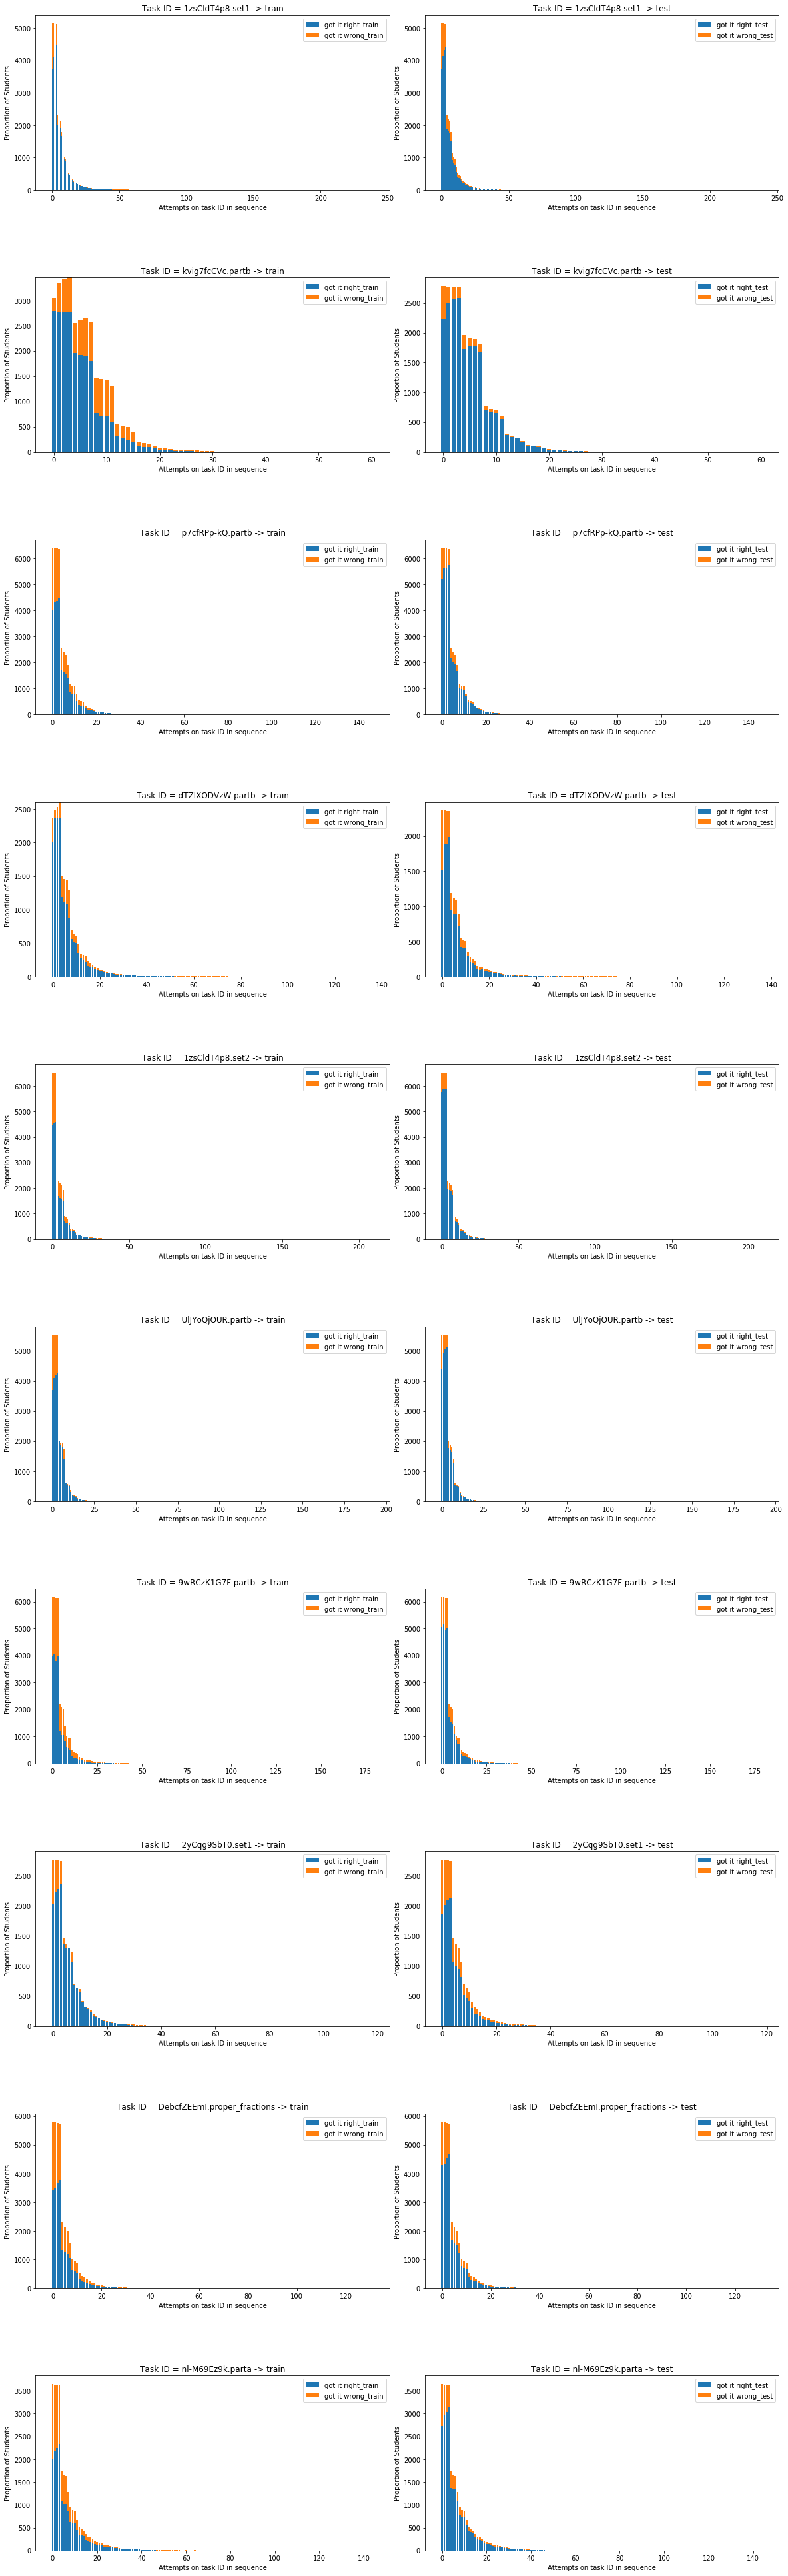

In [18]:
fig, axs = plt.subplots(10,2, figsize=(20, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.10)

axs = axs.ravel()
for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    for k in ['train','test']:
        if(k=='train'):
            axs[2*i].bar(ind,proportion_right_train[value],label="got it right_train")
            axs[2*i].bar(ind,proportion_wrong_train[value],bottom = proportion_right_train[value],label="got it wrong_train")
            #axs[2*i].set_ylim(0,1.31)
            axs[2*i].legend(loc="best") 
            axs[2*i].set_xlabel("Attempts on task ID in sequence")
            axs[2*i].set_ylabel("Proportion of Students")
            axs[2*i].set_title("Task ID = "+str(value) + " -> " + str(k))
        else:
            axs[2*i+1].bar(ind,proportion_right_test[value],label="got it right_test")
            axs[2*i+1].bar(ind,proportion_wrong_test[value],bottom = proportion_right_test[value],label="got it wrong_test")
            #axs[2*i+1].set_ylim(0,1.31)
            axs[2*i+1].legend(loc="best") 
            axs[2*i+1].set_xlabel("Attempts on task ID in sequence")
            axs[2*i+1].set_ylabel("Proportion of Students")
            axs[2*i+1].set_title("Task ID = "+str(value) + " -> " + str(k))
plt.savefig('right_wrong_10x.png')

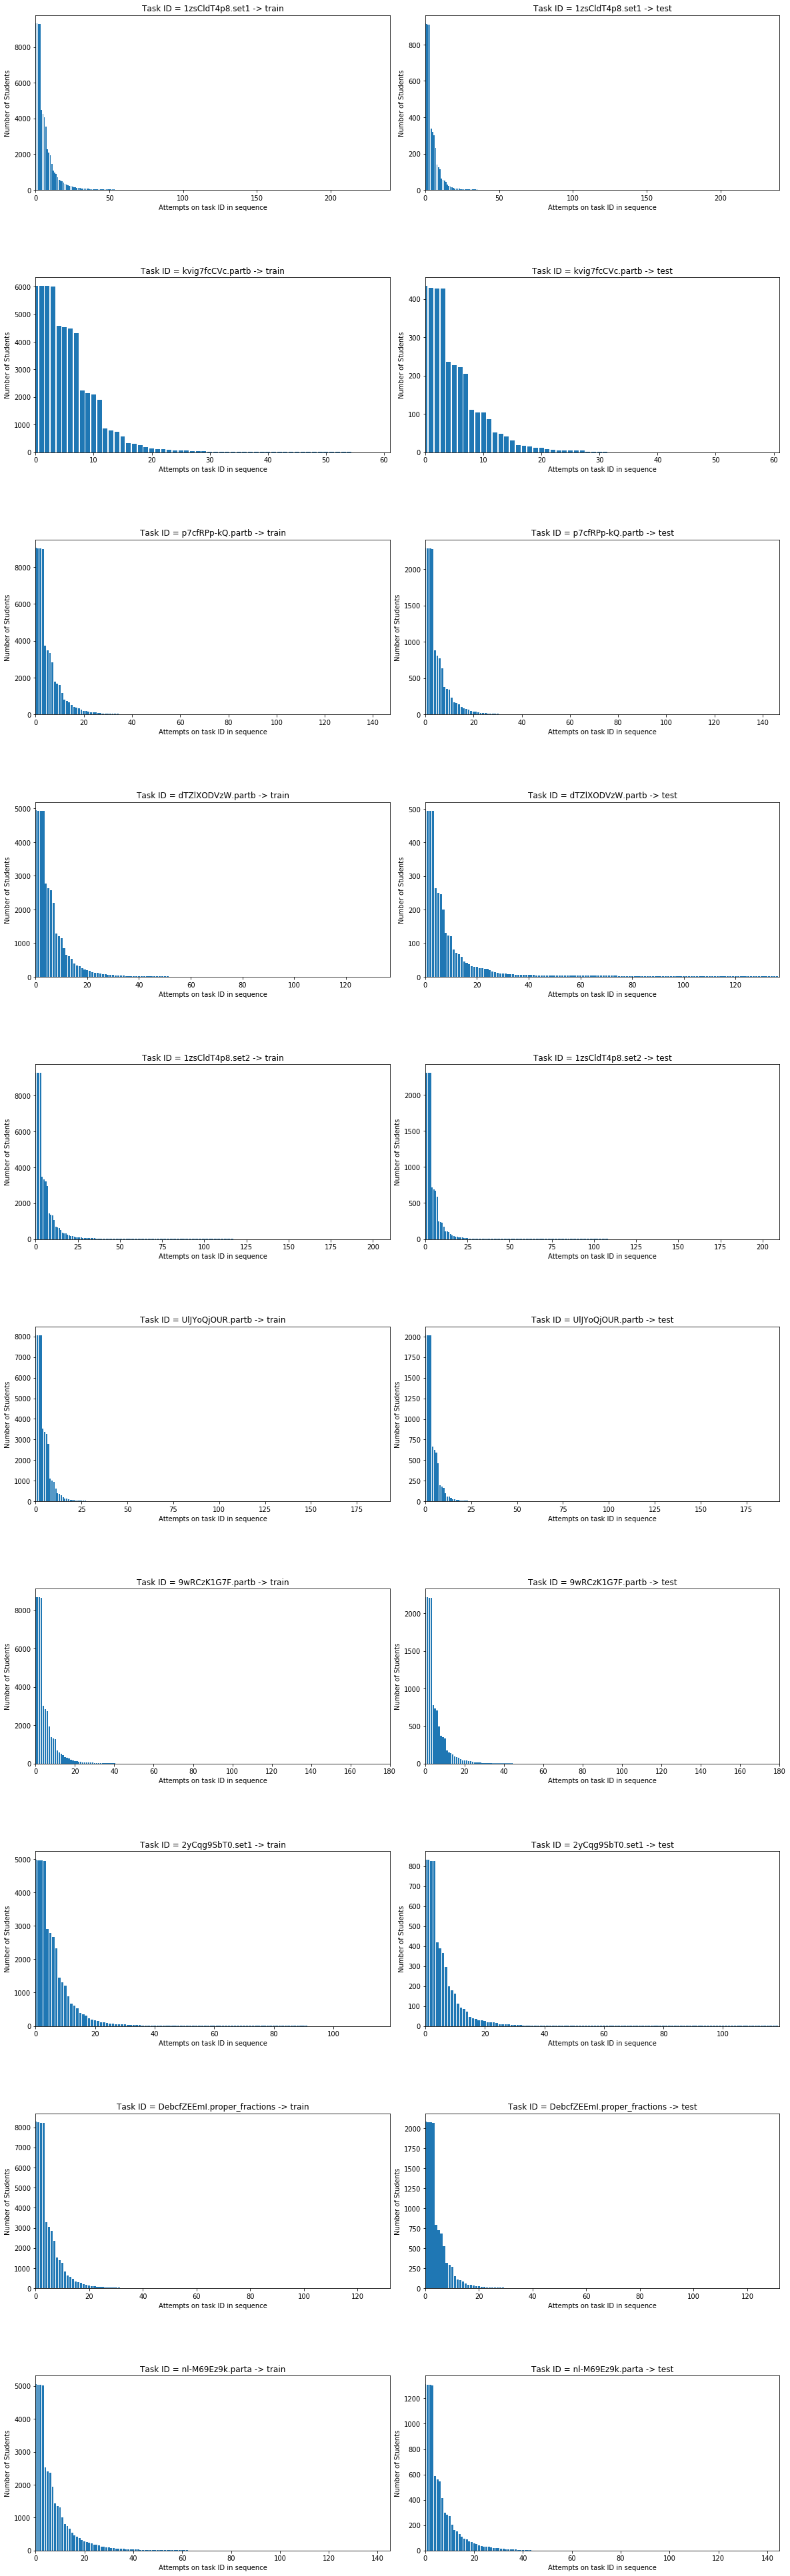

In [108]:
fig, axs = plt.subplots(10,2, figsize=(20, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.1)

axs = axs.ravel()

for i,value in enumerate(another_2):
    N = max(seqlen_tasks[value])
    ind = np.arange(N)
    for k in ['train','test']:
        if k=='train':
            axs[2*i].bar(ind,num_of_students_train[value])
            #axs[2*i].set_ylim(0,2000)
            axs[2*i].set_xlim(0,max(seqlen_tasks[value]))
            axs[2*i].set_xlabel("Attempts on task ID in sequence")
            axs[2*i].set_ylabel("Number of Students")
            axs[2*i].set_title("Task ID = "+str(value) + " -> " + k)
        else:
            axs[2*i+1].bar(ind,num_of_students_test[value])
            #axs[2*i+1].set_ylim(0,1300)
            axs[2*i+1].set_xlim(0,max(seqlen_tasks[value]))
            axs[2*i+1].set_xlabel("Attempts on task ID in sequence")
            axs[2*i+1].set_ylabel("Number of Students")
            axs[2*i+1].set_title("Task ID = "+str(value) + " -> " + k)
plt.savefig('num_students.png')